### Solving Aiyagari (1994) model
#### 07/2019

#### Calibrating the Markov process


We need to calibrate the markov process so that:

\begin{equation}
\begin{bmatrix}
e & u
\end{bmatrix}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
e & u
\end{bmatrix}
\end{equation}

with $e = 0.9 \text{ and } \pi_{ee} = 0.9$

We get that:
\begin{equation}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
0.9 & 0.1 \\
0.9 & 0.1
\end{bmatrix}
\end{equation}

In [60]:
import numpy as np
from scipy import interpolate
import numba as nb

#Economic parameters
Π = np.array([[0.9,0.1], [0.9, 0.1]] )
Uss = 0.1
α = 0.36
β = 0.96
δ = 0.06



# Basic functions

# Return on capital
rf = lambda k,u: α*k**(α - 1) * (1 - u)** (1 - α )


# Return on labor
wf = lambda k,u: (1-α)*k**(α ) * (1 - u)** (- α )


#Aggregate labor supply
Lf = lambda u: 1 - u


#Utility
def u(c):
    if c > 0:
        return np.log(c)
    else:
        return -500000000

# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)


def Bellman(Kp, *args):
    R, W, Kgrid, Vp, Ε, j, l, Π = args
    
    Today = u(R* Kgrid[j] + W*Ε[l] + (1 - δ) * Kgrid[j] - Kp)
#     print("Value for Today", Today)
    exp= 0
    for i in range(Nϵ):
        exp +=  Π[l,i]*interpolant(Kp,Kgrid,Vp[:,i])  
    
    Value = Today + β * exp

    return - Value



def simulate(Kp, simuT, Π, Kstar, Kgrid):

    np.random.seed(seed=13)
    ϵ = np.random.binomial(1, Π[0,1], simuT)
    Ksimu = np.zeros([simuT])
    
    Ksimu[0] = Kstar*3

    for t in range(1,simuT):
#         print("K simulated",Ksimu[t-1])
        Ksimu[t] = interpolant(Ksimu[t-1], Kgrid, Kp[:,ϵ[t]])
    
    Kstar_new = np.mean(Ksimu[500:])
    
    return Kstar_new
    


#### Compute the steady state equilibrium for K

Return  0.10166666666666672
Wage  1.3033533628105798
Error term for the Value Function:  2.5000000004328067e+17
Error term for the Value Function:  2.4749623951701955e+19


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Error term for the Value Function:  9.630946249325113e+18


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Error term for the Value Function:  2.162532937897888e+37
Error term for the Value Function:  6.312037903516729e+55


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Error term for the Value Function:  2.237549923475484e+74
Error term for the Value Function:  5.89374350755129e+90
Error term for the Value Function:  3.5324446570869217e+106
Error term for the Value Function:  2.1132509031023684e+122
Error term for the Value Function:  1.2668881457011642e+138
Error term for the Value Function:  7.594959792040089e+153
Error term for the Value Function:  4.5531576383002885e+169
Error term for the Value Function:  2.7296055603796336e+185
Error term for the Value Function:  1.636391073434654e+201
Error term for the Value Function:  9.810119762667169e+216
Error term for the Value Function:  5.881139986658311e+232


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Error term for the Value Function:  3.5257273488440523e+248
Error term for the Value Function:  2.1136639098179525e+264
Error term for the Value Function:  1.2671357372916702e+280
Error term for the Value Function:  7.596444114239487e+295


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2

Error term for the Value Function:  inf


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: Runt

Error term for the Value Function:  inf


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarn

Error term for the Value Function:  inf


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarn

Error term for the Value Function:  inf
Error term for the Value Function:  inf


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarn

Error term for the Value Function:  inf
Error term for the Value Function:  inf


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarn

Error term for the Value Function:  nan
Policy Function [[-2.24103765e+008  1.70315130e+000]
 [-2.07643899e+008  3.61687844e+008]
 [-2.09710717e+008  3.61543523e+008]
 [ 3.61646141e+008  7.97959183e+000]
 [ 3.61696765e+008  5.65928972e+000]
 [ 8.71366105e+000 -2.25813497e+008]
 [ 2.68357839e+008 -2.33265635e+008]
 [ 3.61493270e+008 -1.03134677e+009]
 [ 1.66599337e+008  3.61493083e+008]
 [ 3.61700464e+008 -1.62035148e+008]
 [ 3.61722092e+008  3.61493091e+008]
 [ 1.64387754e+000 -8.96413751e+008]
 [-1.69483385e+008  3.61535522e+008]
 [-2.97041233e+008  5.65928972e+000]
 [ 3.61721590e+008  3.61702785e+008]
 [ 9.03555448e+007  2.67829733e+008]
 [ 1.05213480e+009  3.61493090e+008]
 [ 3.61661279e+008  2.25933178e+008]
 [-7.70506733e+204 -2.33265635e+008]
 [ 7.97959183e+000  7.97959183e+000]
 [ 7.97959183e+000  2.25933185e+008]
 [ 8.92113404e+007  7.97959183e+000]
 [ 7.97959183e+000  5.65928972e+000]
 [ 7.97959183e+000 -2.02038138e+008]
 [ 5.74331793e+008  3.61500107e+008]
 [ 3.61711472e+008 

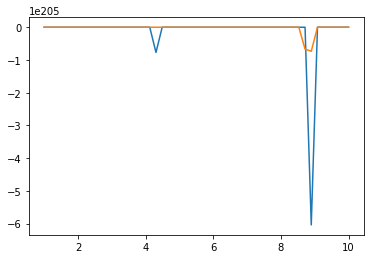

Value Function [[-1.27962405e+210 -1.55757699e+115]
 [-1.18563884e+210  9.81401508e+118]
 [-1.19744029e+210  9.81009845e+118]
 [ 9.81288334e+118 -1.55673962e+115]
 [ 9.81425716e+118 -1.73038825e+115]
 [-1.33959518e+115 -1.28938655e+210]
 [ 7.28120285e+118 -1.33193798e+210]
 [ 9.80873469e+118 -5.88895107e+210]
 [ 4.51965604e+118  9.80872961e+118]
 [ 9.81435756e+118 -9.25214590e+209]
 [ 9.81494450e+118  9.80872981e+118]
 [-1.55750761e+115 -5.11848865e+210]
 [-9.67743742e+209  9.80988132e+118]
 [-1.69609423e+210 -1.73038825e+115]
 [ 9.81493088e+118  9.81442055e+118]
 [ 2.45053359e+118  7.26687097e+118]
 [ 2.85515315e+119  9.80872980e+118]
 [ 9.81329414e+118  6.12987215e+118]
 [             nan -1.33193798e+210]
 [-1.55673962e+115 -1.55673961e+115]
 [-1.55673961e+115  6.12987233e+118]
 [ 2.41948190e+118 -1.55673962e+115]
 [-1.55673966e+115 -1.73038825e+115]
 [-1.55673962e+115 -1.15363015e+210]
 [ 1.55847979e+119  9.80892023e+118]
 [ 9.81465628e+118  9.81337232e+118]
 [ 9.80872961e+118  9.8

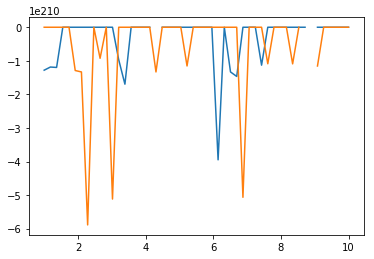

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


New value for Kstar -inf
Error term for K*:  nan
Return  0.0
Wage  inf
Error term for the Value Function:  nan
Policy Function [[-2.24103765e+008  1.70315130e+000]
 [-2.07643899e+008  3.61687844e+008]
 [-2.09710717e+008  3.61543523e+008]
 [ 3.61646141e+008  7.97959183e+000]
 [ 3.61696765e+008  5.65928972e+000]
 [ 8.71366105e+000 -2.25813497e+008]
 [ 2.68357839e+008 -2.33265635e+008]
 [ 3.61493270e+008 -1.03134677e+009]
 [ 1.66599337e+008  3.61493083e+008]
 [ 3.61700464e+008 -1.62035148e+008]
 [ 3.61722092e+008  3.61493091e+008]
 [ 1.64387754e+000 -8.96413751e+008]
 [-1.69483385e+008  3.61535522e+008]
 [-2.97041233e+008  5.65928972e+000]
 [ 3.61721590e+008  3.61702785e+008]
 [ 9.03555448e+007  2.67829733e+008]
 [ 1.05213480e+009  3.61493090e+008]
 [ 3.61661279e+008  2.25933178e+008]
 [-7.70506733e+204 -2.33265635e+008]
 [ 7.97959183e+000  7.97959183e+000]
 [ 7.97959183e+000  2.25933185e+008]
 [ 8.92113404e+007  7.97959183e+000]
 [ 7.97959183e+000  5.65928972e+000]
 [ 7.97959183e+000 -2.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramDat

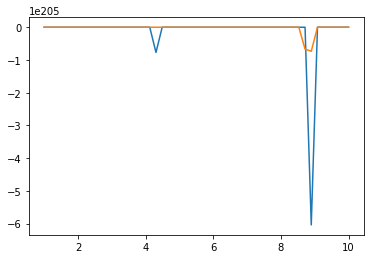

Value Function [[             inf  8.47915109e+118]
 [             inf -5.34254489e+122]
 [             inf -5.34041275e+122]
 [             inf  8.47459265e+118]
 [             inf  9.41990257e+118]
 [             nan -9.98336016e+217]
 [             inf -1.03128240e+218]
 [             inf -4.55965044e+218]
 [             inf -5.33966759e+122]
 [             inf -7.16367833e+217]
 [             inf -5.33966770e+122]
 [             inf -3.96310290e+218]
 [             inf -5.34029455e+122]
 [             inf  9.41990257e+118]
 [             inf -5.34276562e+122]
 [             inf -3.95593282e+122]
 [             inf -5.33966769e+122]
 [             inf -3.33697440e+122]
 [             nan -1.03128240e+218]
 [             inf  8.47459259e+118]
 [             inf -3.33697450e+122]
 [             inf  8.47459265e+118]
 [             inf  9.41990257e+118]
 [             inf -8.93223624e+217]
 [             inf -5.33977136e+122]
 [             inf -5.34219498e+122]
 [             inf -5.3

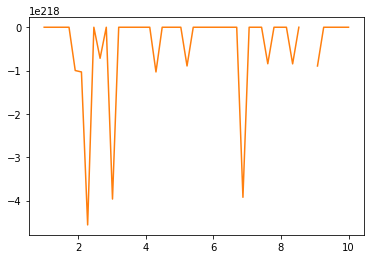

New value for Kstar -inf
Error term for K*:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Computational parameters
N = 50
Nϵ = 2
epsi = 1
epsi2 = 1
tol = 1e-6
maxiter = 2000
simuT = 10000


# Make grid
Klow   = 1
Khigh  = 10
Kgrid = np.linspace(Klow, Khigh, N)

#Steady State capital
Kstar = ( (1/β - 1+δ) /(α*(1-Uss)**(1-α))) ** (1 / (α - 1))
Ustar = Uss
Ε = np.array([1,0])


iter  = 0
iter2 = 0
Vp=Kstar/6*np.ones([N,Nϵ])
Kp=Kstar/6*np.ones([N,Nϵ])
Vp_new=np.zeros([N,Nϵ])
Kp_new=np.zeros([N,Nϵ])



while (epsi2 > tol) & (iter2 < maxiter):
    epsi = 1
    iter = 0
    # Dynamic Programming Step
    ##########################
    R = rf(Kstar, Ustar)
    print("Return ", R)
    W = wf(Kstar, Ustar)
    print("Wage ", W)
    
    while (epsi > tol) & (iter < maxiter):
    
        for j in range(N):

            for l in range(Nϵ):

                params = R, W, Kgrid, Vp, Ε, j, l, Π
                solve = minimize(Bellman,Kp[j,l], args=(params))
                Kp_new[j,l] = solve.x
                Vp_new[j,l] = - solve.fun
                

        epsi = ((Vp_new - Vp) ** 2).sum()
        print("Error term for the Value Function: ", epsi)
        #Update
        Kp=Kp_new*1.
        Vp = Vp_new*1.
        iter=iter+1
        
    print("Policy Function",Kp_new)
    plt.plot(Kgrid, Kp_new[:,0])
    plt.plot(Kgrid, Kp_new[:,1])
    plt.show()
    print("Value Function",Vp_new)
    plt.plot(Kgrid, Vp_new[:,0])
    plt.plot(Kgrid, Vp_new[:,1])
    plt.show()
    
    # Simulation step
    #################
    Kstar_new = simulate(Kp, simuT, Π, Kstar, Kgrid)
    print("New value for Kstar", Kstar_new)
    epsi2 = (Kstar_new - Kstar) ** 2
    print("Error term for K*: ", epsi)
    Kstar = Kstar_new
        
    iter2=iter2+1


    

In [ ]:
print(Π[1,0])

In [ ]:
print(Kstar)

In [7]:
print(Ksimu)

[-1.86234901e+180              inf             -inf ...  0.00000000e+000
  0.00000000e+000  0.00000000e+000]
